# M5 - W4 Assignment: Unsupervised Learning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error

In [2]:
train=pd.read_csv(r'C:\Users\User\Desktop\ELU\weekly assignments\module5\week4\train.csv',sep=';')
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [3]:
test=pd.read_csv(r'C:\Users\User\Desktop\ELU\weekly assignments\module5\week4\test.csv',sep=';')
test.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


In [4]:
sample=pd.read_csv(r'C:\Users\User\Desktop\ELU\weekly assignments\module5\week4\sample_submission.csv',sep=';')
sample.head()

,ID,y
0,1,100.669.318.127.821
1,2,100.669.318.127.821
2,3,100.669.318.127.821
3,4,100.669.318.127.821
4,5,100.669.318.127.821


In [16]:
# Check for null values in the dataframe
null_values = train.isnull().sum()

#Print the number of null values in each column
print('sum of null values:')
print(null_values)

sum of null values:
ID      0
y       0
X0      0
X1      0
X2      0
       ..
X380    0
X382    0
X383    0
X384    0
X385    0
Length: 378, dtype: int64


In [18]:
print('Number of duplicates:',train.duplicated().sum())

Number of duplicates: 0


**************************

# EDA

In [6]:
train.loc[:, train.isnull().any()]   
train.columns[train.isnull().any()]  
train[train.isnull().any(axis=1)]    

test[test.isnull().any(axis=1)]

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385


In [7]:
cat_features = train.columns[train.dtypes == 'object']
cat_features

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'], dtype='object')

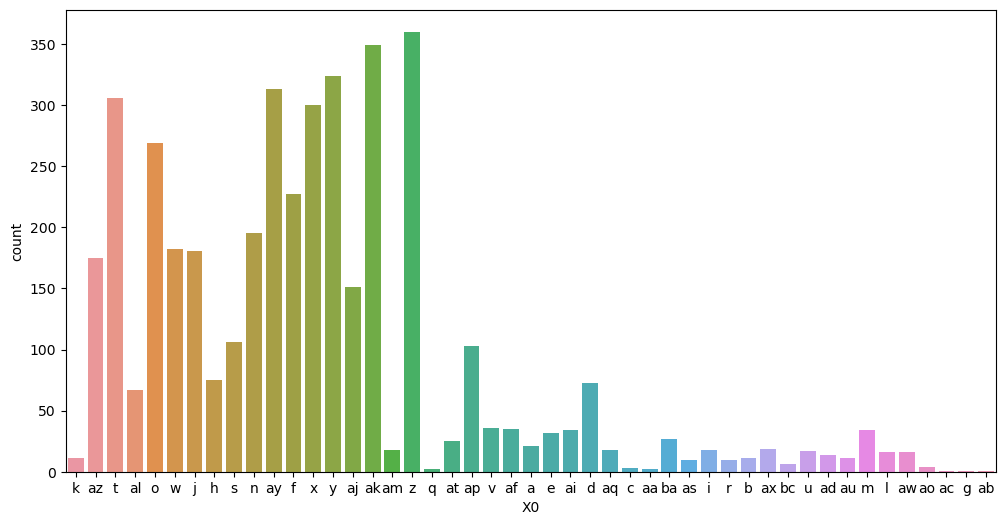

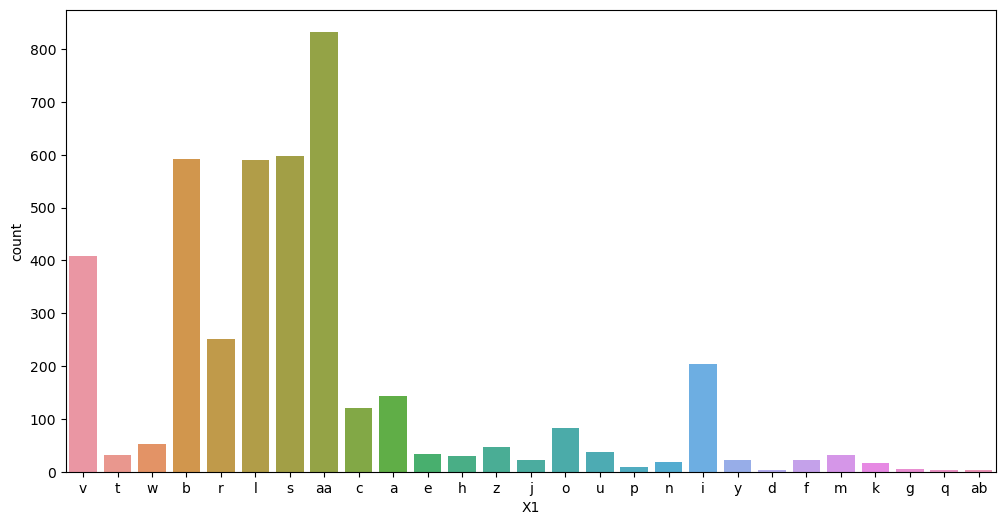

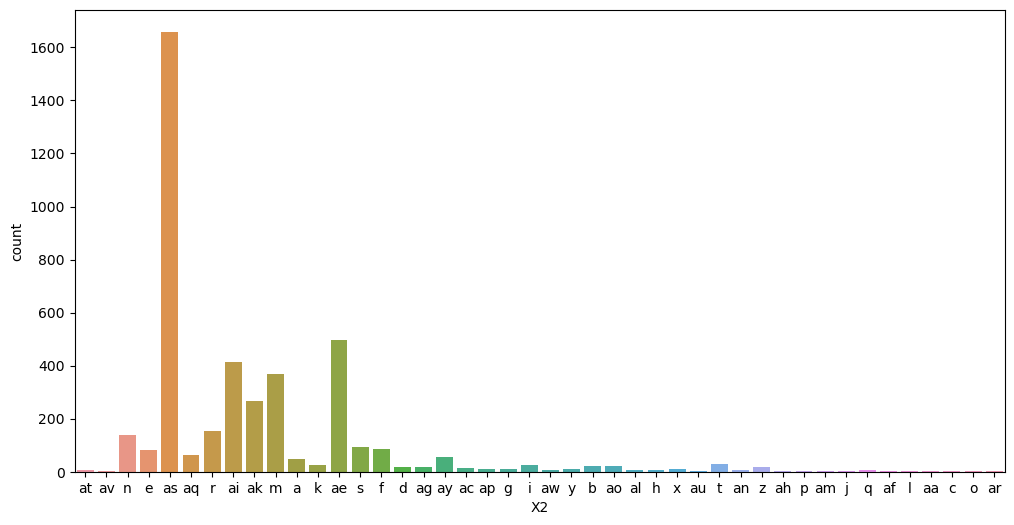

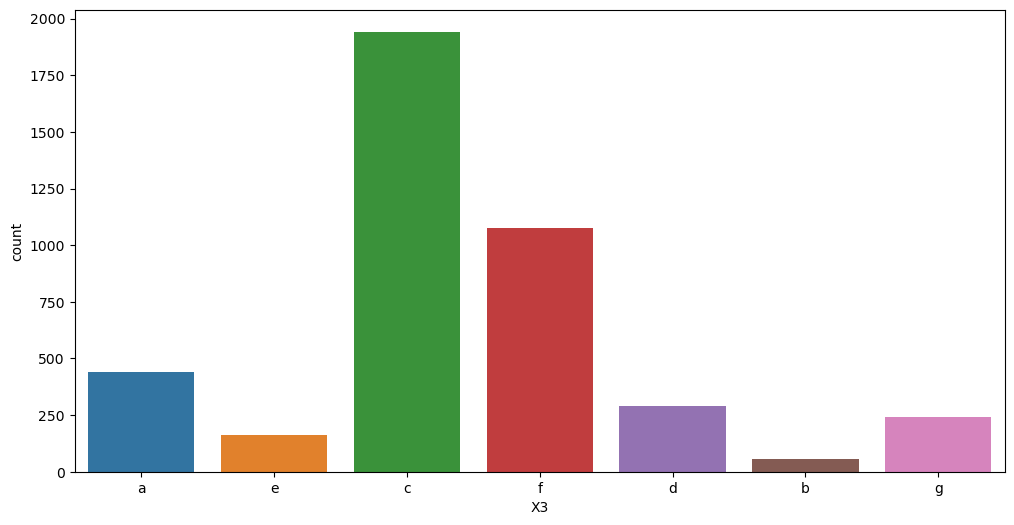

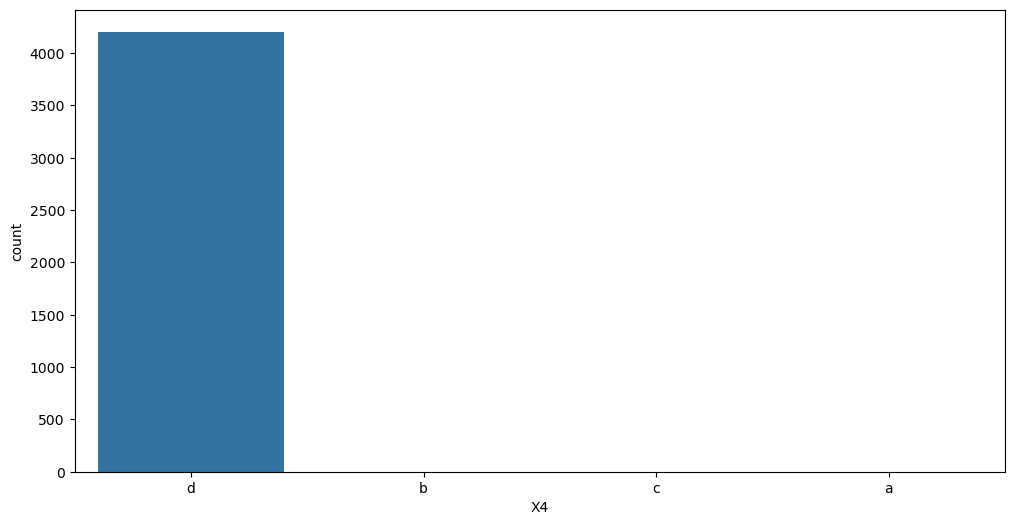

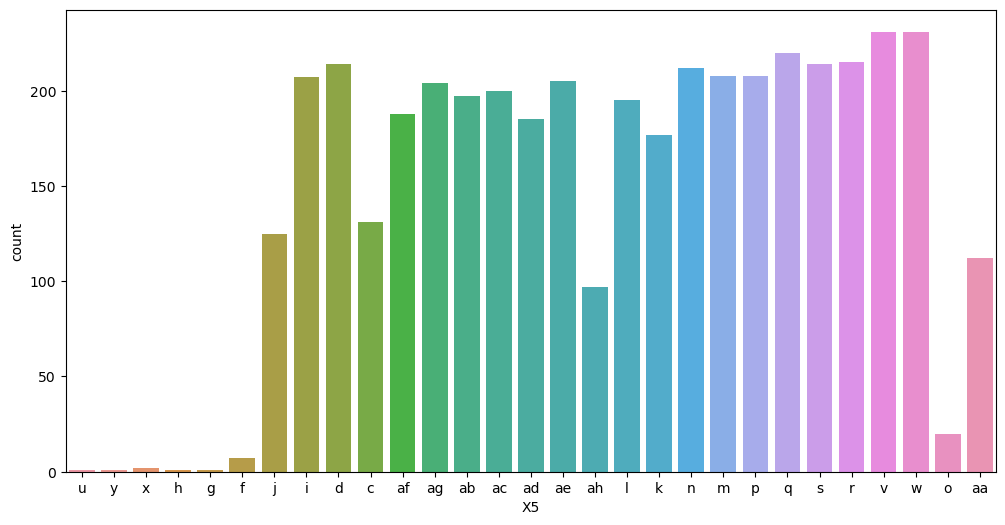

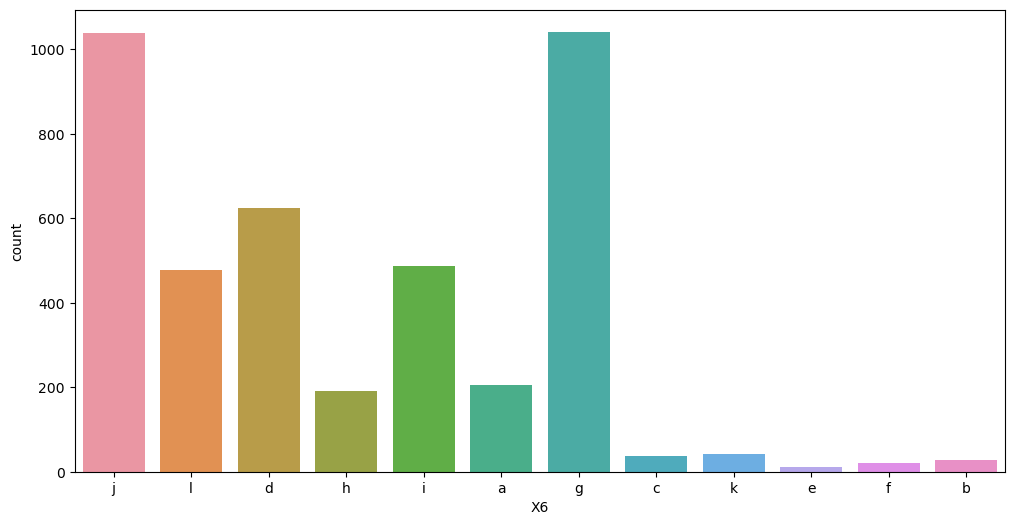

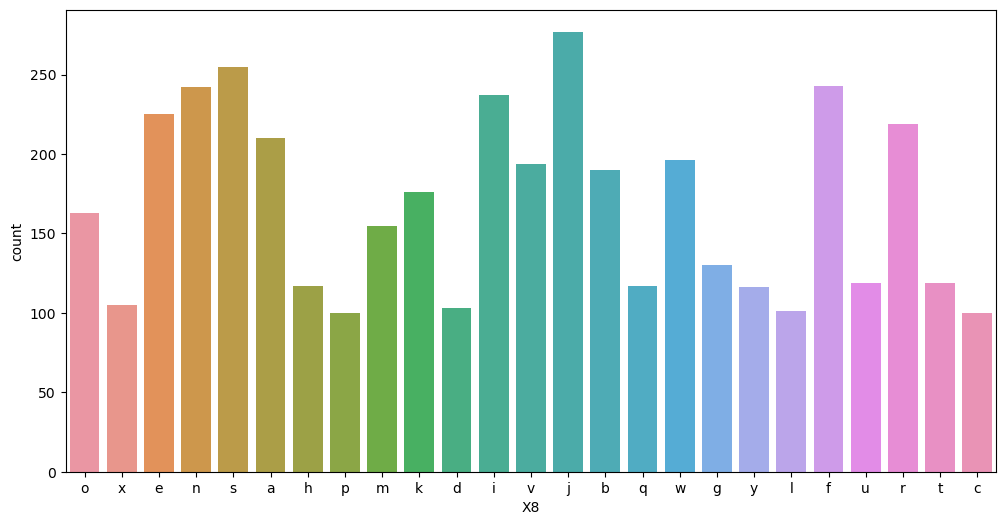

In [8]:
for col in cat_features:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=train, x=col) # X0 ~ X8
    plt.show()

min: 72.11 max: 265.32 mean: 100.66931812782134 std: 12.6778749695168
Count of values above 180: 1


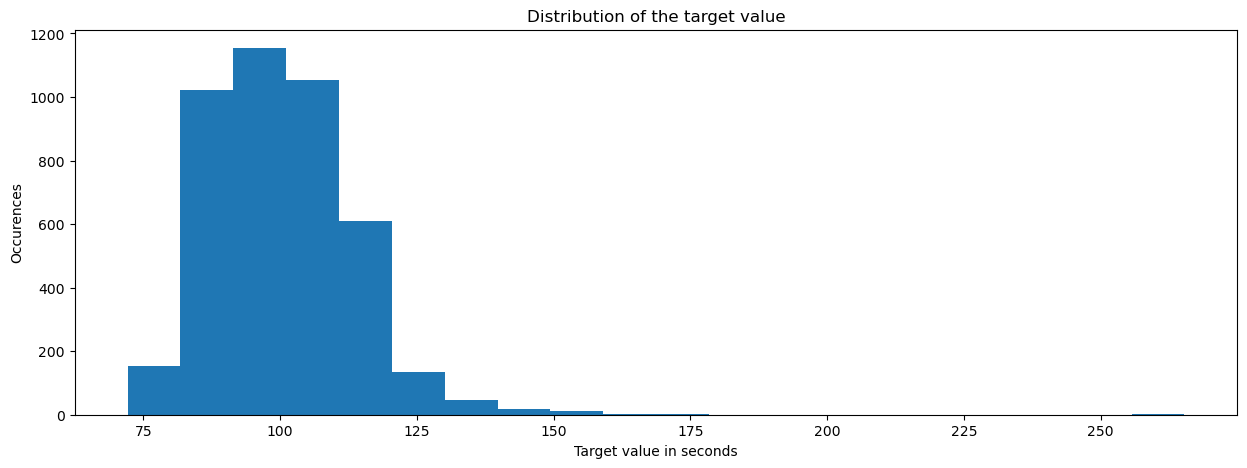

In [14]:
y_train = train['y'].values
plt.figure(figsize=(15, 5))
plt.hist(y_train, bins=20)
plt.xlabel('Target value in seconds')
plt.ylabel('Occurences')
plt.title('Distribution of the target value')

print('min: {} max: {} mean: {} std: {}'.format(min(y_train), max(y_train), y_train.mean(), y_train.std()))
print('Count of values above 180: {}'.format(np.sum(y_train > 200)))

So we have a pretty standard distribution here, which is centred around almost exactly 100. Nothing special to note here, except there is a single outlier at 265 seconds where every other value is below 180.

The fact that our ID is not equal to the row ID seems to suggest that the train and test sets were randomly sampled from the same dataset, which could have some special order to it.

*********************************

# PCA

Before we move to the PCA process we need to normalize the data first:

In [4]:
def object_to_int(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

train = train.apply(lambda x: object_to_int(x))
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,32,23,17,0,3,24,9,14,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,32,21,19,4,3,28,11,14,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,20,24,34,2,3,27,9,23,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,20,21,34,5,3,27,11,4,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,20,23,34,5,3,12,3,13,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Extract numeric columns
numeric_cols = train.select_dtypes(include='number').columns

# Normalize the numeric columns
scaler = StandardScaler()
train[numeric_cols] = scaler.fit_transform(train[numeric_cols])
train.head()


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,-1.725650,2.377424,0.163012,1.393488,-0.028122,-1.678270,0.028938,1.292117,0.751787,0.339445,...,-0.684167,-0.246447,1.475332,-0.14528,-0.097952,-0.090243,-0.087527,-0.040815,-0.021804,-0.037783
1,-1.723189,-0.957520,0.163012,1.159021,0.155388,0.620969,0.028938,1.776974,1.437511,0.339445,...,1.461630,-0.246447,-0.677814,-0.14528,-0.097952,-0.090243,-0.087527,-0.040815,-0.021804,-0.037783
2,-1.722778,-1.925348,-0.710560,1.510721,1.531709,-0.528650,0.028938,1.655760,0.751787,1.618389,...,-0.684167,-0.246447,-0.677814,-0.14528,-0.097952,-0.090243,11.425027,-0.040815,-0.021804,-0.037783
3,-1.721958,-1.581442,-0.710560,1.159021,1.531709,1.195779,0.028938,1.655760,1.437511,-1.081605,...,-0.684167,-0.246447,-0.677814,-0.14528,-0.097952,-0.090243,-0.087527,-0.040815,-0.021804,-0.037783
4,-1.720317,-1.786523,-0.710560,1.393488,1.531709,1.195779,0.028938,-0.162454,-1.305384,0.197340,...,-0.684167,-0.246447,-0.677814,-0.14528,-0.097952,-0.090243,-0.087527,-0.040815,-0.021804,-0.037783


In [ ]:
y = train['y']
X = train.drop(['ID','y'], axis = 1)

First we will check the correlation of X:

In [18]:
X.corr()

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
X0,1.000000,-0.271123,-0.139904,-0.070645,0.017988,0.012293,0.037549,0.047735,0.081122,NaN,...,0.113272,0.070546,0.045173,-0.102136,0.083352,-0.038618,-0.060401,-0.011174,0.009110,0.011660
X1,-0.271123,1.000000,0.088266,0.205657,-0.020724,0.046417,-0.079119,-0.000306,-0.137193,NaN,...,0.056874,-0.102424,-0.248791,0.145282,0.070753,-0.022360,0.120044,-0.029253,0.017603,0.008356
X2,-0.139904,0.088266,1.000000,-0.093546,0.002289,-0.017722,0.065778,-0.069932,0.042398,NaN,...,-0.174308,0.033697,0.122503,0.131974,0.033645,0.006473,0.024392,-0.019873,-0.002614,-0.004529
X3,-0.070645,0.205657,-0.093546,1.000000,0.015298,-0.008161,-0.048468,-0.001249,0.019663,NaN,...,0.051801,-0.105009,-0.588272,0.173723,-0.026446,0.004166,-0.046271,-0.028280,0.007273,0.045180
X4,0.017988,-0.020724,0.002289,0.015298,1.000000,0.039778,0.027854,-0.008909,0.003360,NaN,...,-0.021598,0.007132,0.012692,0.004204,0.002835,0.002611,0.002533,0.001181,0.000631,0.001093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X380,-0.038618,-0.022360,0.006473,0.004166,0.002611,0.010434,-0.014059,0.009511,-0.010479,NaN,...,-0.061741,-0.022240,-0.061168,-0.013110,-0.008839,1.000000,-0.007899,-0.003683,-0.001968,-0.003410
X382,-0.060401,0.120044,0.024392,-0.046271,0.002533,-0.031128,0.054548,-0.000996,-0.010164,NaN,...,-0.059883,-0.021571,-0.059327,-0.012716,-0.008573,-0.007899,1.000000,-0.003572,-0.001908,-0.003307
X383,-0.011174,-0.029253,-0.019873,-0.028280,0.001181,-0.007337,-0.021293,0.038712,-0.004740,NaN,...,-0.015413,-0.010059,0.035107,-0.005930,-0.003998,-0.003683,-0.003572,1.000000,-0.000890,-0.001542
X384,0.009110,0.017603,-0.002614,0.007273,0.000631,0.007030,0.023867,0.008950,-0.002532,NaN,...,-0.014917,-0.005373,0.008694,-0.003168,-0.002136,-0.001968,-0.001908,-0.000890,1.000000,-0.000824


Now we can use the Prinipal Component Analysis(PCA) in our predictors:

In [20]:
pca=PCA().fit(X)
#transformed data
transf=pca.transform(X)
transf

array([[ 1.22544667e+01, -2.94420951e+00, -9.57849872e-01, ...,
         1.53436291e-15, -1.05818132e-16, -4.52849563e-15],
       [-1.02545670e-01,  3.66061642e-01,  9.97224047e-01, ...,
         1.72518250e-15, -2.71137279e-15,  1.71650888e-15],
       [ 1.02783182e+01,  2.11049278e+01, -5.01329942e+00, ...,
        -2.99673480e-15,  4.21537805e-16,  4.66076830e-15],
       ...,
       [ 4.36968281e-01,  8.97529347e-01,  3.44522225e+00, ...,
        -7.54604712e-17,  3.38271078e-16,  5.81132364e-17],
       [-1.34167187e+00,  5.89252655e-01, -1.09654887e-01, ...,
         7.38124839e-16, -1.78676518e-16, -1.12236609e-15],
       [-2.16821336e+00, -1.06043018e+00, -2.88075121e-01, ...,
        -3.03576608e-17,  6.60929644e-16, -7.01695646e-16]])

<AxesSubplot:>

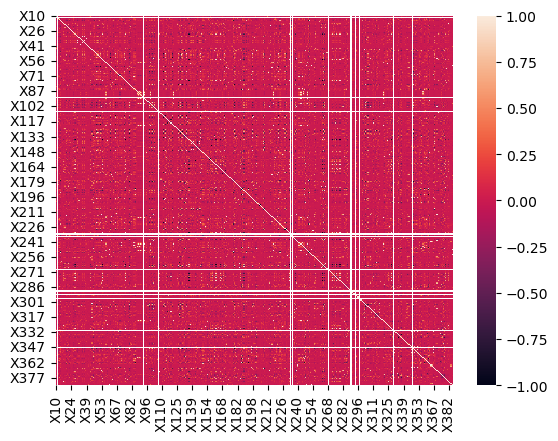

In [8]:
plt.clf()
sns.heatmap(X.corr())


<AxesSubplot:>

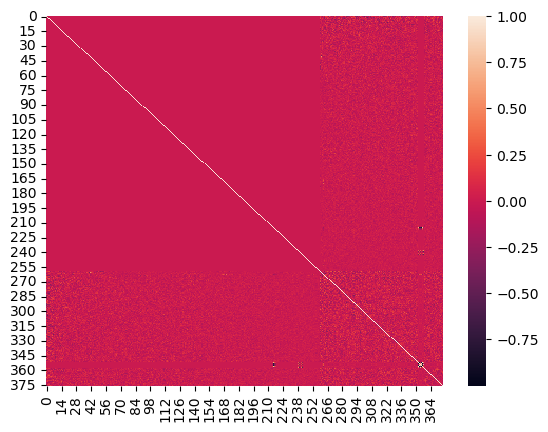

In [9]:
sns.heatmap(pd.DataFrame(transf).corr())

As it looks like the PCA is done and there are no correlation between our values.

Now we have to select the number of components and check how much of the variance each component can explain:

In [35]:
np.cumsum(pca.explained_variance_ratio_)

array([0.06892669, 0.12581081, 0.17118538, 0.20545309, 0.23809618,
       0.26972279, 0.29834803, 0.31958554, 0.33928968, 0.35712163,
       0.3735223 , 0.38916516, 0.40379258, 0.41827593, 0.43175879,
       0.44471041, 0.45714873, 0.46887976, 0.48009027, 0.49086305,
       0.50078818, 0.51048267, 0.5199079 , 0.52900658, 0.53774882,
       0.54617951, 0.55408156, 0.56171374, 0.56904916, 0.57619821,
       0.58312778, 0.58989456, 0.5964199 , 0.60283484, 0.60906176,
       0.61505372, 0.62093459, 0.62668152, 0.63231855, 0.63785265,
       0.64335906, 0.64875988, 0.65409899, 0.6593451 , 0.66444705,
       0.66947937, 0.67443823, 0.67916514, 0.68380989, 0.68837511,
       0.69277135, 0.69710083, 0.70140405, 0.70564167, 0.70984379,
       0.71399853, 0.71806552, 0.72210015, 0.72601889, 0.72990636,
       0.73372396, 0.73747956, 0.74120396, 0.74486306, 0.74845873,
       0.75201102, 0.75550803, 0.75896986, 0.76237457, 0.76571615,
       0.769026  , 0.77228122, 0.77552207, 0.77873252, 0.78189

Let's plot the number of components:

Text(0, 0.5, 'Cumsum variance ratio')

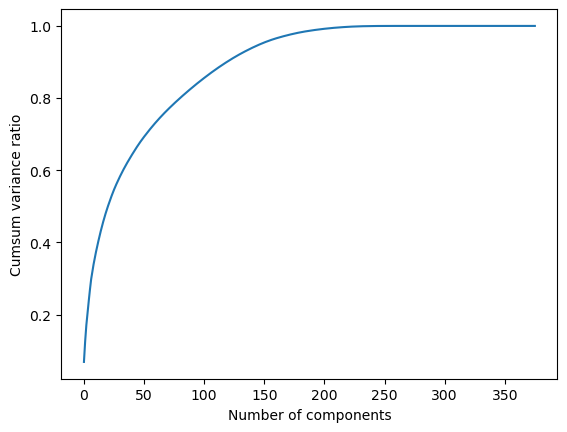

In [29]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumsum variance ratio')

In [10]:
y.value_counts()

91.88     7
89.38     7
89.06     7
90.76     7
89.19     6
         ..
110.90    1
132.60    1
94.08     1
75.89     1
87.48     1
Name: y, Length: 2545, dtype: int64

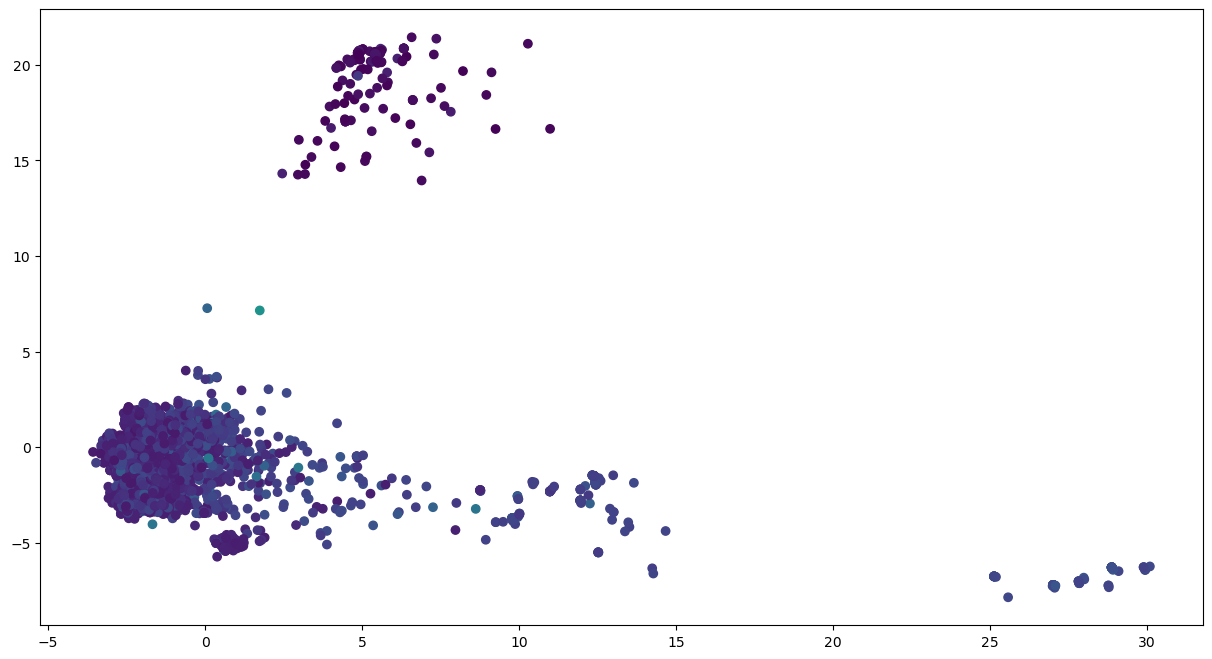

In [17]:
plt.figure(figsize=(15,8))
plt.scatter(transf[:,0],transf[:,1],c=y)

We will try to fit a linear regrassion model and see the difference for the PCA


In [22]:
cv=KFold(n_splits=3)
lr=LinearRegression()
preds=cross_val_predict(estimator=lr,cv=cv,X=X,y=y)
print(mean_absolute_error(y,preds))

807363711804.8479


In [28]:
for cum_components in range(1,X.shape[1]+1):

    print(f"Number of components used: {cum_components }")
    X_pca=transf[:,:cum_components]
    lr=LinearRegression()
    preds=cross_val_predict(estimator=lr,cv=cv,X=X_pca,y=y)

    pca_mae= mean_absolute_error(y,preds)
    print(f"MAE on {cum_components}: {pca_mae}")
    

Number of components used: 1
MAE on 1: 0.7707171683763789
Number of components used: 2
MAE on 2: 0.7196316934631342
Number of components used: 3
MAE on 3: 0.6691793494088457
Number of components used: 4
MAE on 4: 0.6421830241597324
Number of components used: 5
MAE on 5: 0.6225662329545076
Number of components used: 6
MAE on 6: 0.5999048953744939
Number of components used: 7
MAE on 7: 0.600561596435522
Number of components used: 8
MAE on 8: 0.6000671276037655
Number of components used: 9
MAE on 9: 0.5971776763500742
Number of components used: 10
MAE on 10: 0.5970719892167322
Number of components used: 11
MAE on 11: 0.5975802134120256
Number of components used: 12
MAE on 12: 0.5962981789044149
Number of components used: 13
MAE on 13: 0.5897945091149128
Number of components used: 14
MAE on 14: 0.5868579440009831
Number of components used: 15
MAE on 15: 0.5851400456693175
Number of components used: 16
MAE on 16: 0.5799418946038878
Number of components used: 17
MAE on 17: 0.5773951298226938

Lets plot now the predictions:

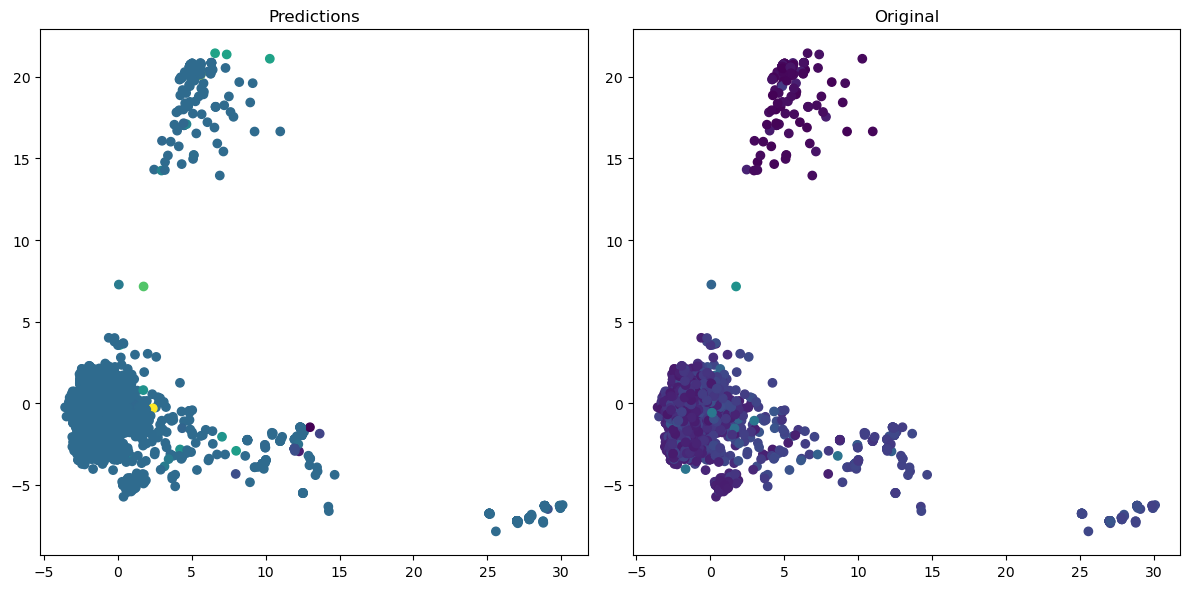

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Prections scatter plot
axes[0].scatter(transf[:, 0], transf[:, 1], c=preds)
axes[0].set_title("Predictions")

# Original scatter plot
axes[1].scatter(transf[:, 0], transf[:, 1], c=y)
axes[1].set_title("Original")

plt.tight_layout()
plt.show()


<AxesSubplot:>

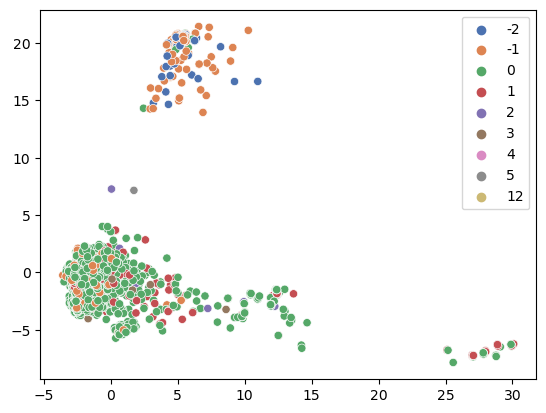

In [35]:
sns.scatterplot(x=transf[:,0],y=transf[:,1],hue=[int(i) for i in y],palette="deep")

In [37]:
lr.fit(X,y)

{name: value for name,value in zip(X.columns,lr.coef_)}

{'X0': 0.07083034093155835,
 'X1': -0.012023970971626677,
 'X2': -0.003064131053931246,
 'X3': -0.018187930926396395,
 'X4': -0.009972450560624721,
 'X5': -0.03477809534949805,
 'X6': 0.006802574367427122,
 'X8': 4.365669140213649e-05,
 'X10': 345041533439.10944,
 'X11': 1034260808742.2705,
 'X12': 793564331664.31,
 'X13': 166512185651.0801,
 'X14': 1490087716525.6025,
 'X15': -546359946953.28326,
 'X16': 153749586303.1975,
 'X17': -3010298281551.3735,
 'X18': 265603388359.09122,
 'X19': 901618911849.973,
 'X20': 1053578492884.8911,
 'X21': -582304299812.9613,
 'X22': 848539631553.0511,
 'X23': 428459736345.4198,
 'X24': -118680683407.97981,
 'X26': 212182411059.23843,
 'X27': -0.00643157958984375,
 'X28': 534392758495.8281,
 'X29': -2921984030282.7676,
 'X30': 201873916226.11536,
 'X31': 921538023254.6418,
 'X32': 316443633878.95544,
 'X33': -1637670555668.706,
 'X34': 222003553577.53464,
 'X35': -6084639833.968849,
 'X36': 201873916226.22977,
 'X37': -915453383420.6475,
 'X38': -0.01

To find the features with the highest absolute correlation with each of the components obtained from Principal Component Analysis (PCA), we will do this:

In [26]:
# Calculate the correlation matrix between original features and PCA components
correlation_matrix = np.corrcoef(X.T, transf.T)
selected_features = []
threshold = 0.75

# Iterate over each PCA component
for i in range(transf.shape[1]):
    component_correlation = correlation_matrix[:, i]
    absolute_correlation = np.abs(component_correlation)
    high_correlation_features = np.where(absolute_correlation >= threshold)[0]
    selected_features.append(high_correlation_features)

num_selected_features = sum(len(features) for features in selected_features)
print("Number of selected features:", num_selected_features)

# Print the selected features for each PCA component
for i, features in enumerate(selected_features):
    print(f"PCA Component {i+1}: X{list(features)}")


Number of selected features: 1179
PCA Component 1: X[0]
PCA Component 2: X[1]
PCA Component 3: X[2]
PCA Component 4: X[3]
PCA Component 5: X[4]
PCA Component 6: X[5]
PCA Component 7: X[6]
PCA Component 8: X[7]
PCA Component 9: X[8]
PCA Component 10: X[]
PCA Component 11: X[10]
PCA Component 12: X[11]
PCA Component 13: X[12, 172, 184, 216, 242, 243]
PCA Component 14: X[13]
PCA Component 15: X[14]
PCA Component 16: X[15, 316, 372]
PCA Component 17: X[16]
PCA Component 18: X[17, 207]
PCA Component 19: X[18]
PCA Component 20: X[19]
PCA Component 21: X[20]
PCA Component 22: X[21]
PCA Component 23: X[22]
PCA Component 24: X[23]
PCA Component 25: X[24]
PCA Component 26: X[25, 143, 160]
PCA Component 27: X[26, 51, 72, 131, 156, 160, 224, 255, 264, 268, 271, 319, 377]
PCA Component 28: X[27]
PCA Component 29: X[28, 32, 34]
PCA Component 30: X[29, 192]
PCA Component 31: X[30, 36, 636]
PCA Component 32: X[31]
PCA Component 33: X[28, 32, 34]
PCA Component 34: X[33]
PCA Component 35: X[28, 32, 34]


There are 1179 features with absolute correlation with the PCA components of at least 0,75.

Having 1179 features with a correlation of at least 0.75 suggests that these features are highly informative and contribute significantly to the overall variance in the dataset.